<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & Classification (Reddit)

# Problem Statement

   Its been a long time since people can actually travel freely. This serves as a perfect opportunity for travel companies to build new products that provide a niche in the market. Especially after the world opens again, travel industry would probably sky rocket and everyone would offer the nicest deals they can. 
   
   One of the niche identified by this travel agency is the opportunity to create product/service for solotraveler and people who would like to go on road trips, focusing on United States. In order to exploit this particular niche, the manager has asked a market research firm to conduct preliminary analysis on solo traveling and road trips.
    
   In order to find out what people talk about in regards to travel, we will look to analyze posts on Reddit. Reddit is a great platform for discussion, especially in the United States. More than just random posts on Reddit, they also have subreddits that people can go to in order to find content or start a discussion that people in the same group like talking about. 
    
   Based on my findings of what people talk about on Reddit, the company would then like to build their product/services with features that people often discuss about on Reddit and offer lucrative packages.

## Why Reddit for information about USA?

- According to Statista, regional distribution of desktop traffic to Reddit.com as of December 2020, by country, shows that USA has traffic of around 50%.

https://www.statista.com/statistics/325144/reddit-global-active-user-distribution/

### Subreddit - Solotravel
- A place for all of those interested in solo travel to share their experience and stories!
- https://www.reddit.com/r/solotravel


### Subreddit - Road trip
- Whether you enjoy traveling by motorcycle, car, or recreational vehicle this is your destination for everything related to road trips!
- https://www.reddit.com/r/roadtrip

### Data files

* ['solotravel.csv](solotravel.csv): SubReddit for Solotravel raw data
* ['roadtrip.csv](roadtrip.csv): SubReddit for Roadtrip raw data
* ['soloXroad.csv](soloXroad.csv): Merged file of SubReddit for Solotravel and Roadtrip with columns containing subreddit, selftext and title.
* ['cleaned_soloXroad.csv](cleaned_soloXroad.csv): clean version that used for the project.

### Data Dictionary for file used for the project - cleaned_soloXroad

|Feature|Type|Description|
|---|---|---|
|subreddit|object|Name of subreddit the posts belong to|
|selftext|object|Content of the post by users|
|title|object|Title of the post by users|
|alltext|object|Combination of selftext and title|
|clean_text|object|Cleaned text of alltext column|
|classifier|int|1=Solotravel, 0=Roadtrip|

### Imports

In [965]:
import requests
import pandas as pd
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Getting the scikit-learn data set:
from bs4 import BeautifulSoup      
from nltk.stem.porter import PorterStemmer
import regex as re
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes  import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#### Input the Reddit URL to be used for comparison

In [966]:
url1 = 'https://www.reddit.com/r/solotravel.json'
url2 = 'https://www.reddit.com/r/roadtrip.json'

Gather data from Sub Reddit 1

In [967]:
#posts1 = []
#after1 = None

#for a in range(50):
#    if after1 == None:
#        current_url1 = url1
#    else:
#        current_url1 = url1 + '?after=' + after1
#    print(current_url1)
#    res1 = requests.get(current_url1, headers={'User-agent': 'Pony Inc 1.0'})
    
#    if res1.status_code != 200:
#        print('Status error', res1.status_code)
#        break
    
#    current_dict1 = res1.json()
#    current_posts1 = [p['data'] for p in current_dict1['data']['children']]
#    posts1.extend(current_posts1)
#    after1 = current_dict1['data']['after']
    
    # generate a random sleep duration to look more 'natural'
#    sleep_duration = random.randint(2,10)
#    print(sleep_duration)
#    time.sleep(sleep_duration)

In [968]:
# Total number of posts retrieved
len(posts1)

1230

In [969]:
print(len(set([p['name'] for p in posts1]))) # Total number of unique posts by name
print(len(set([p['title'] for p in posts1]))) # Total number of unique posts by title

928
928


Export first subreddit file to CSV

In [970]:
pd.DataFrame(posts1).to_csv('solotravel.csv', index = False)

Gather data from subreddit 2

In [971]:
#posts2 = []
#after2 = None

#for a in range(50):
#    if after2 == None:
#        current_url2 = url2
#    else:
#        current_url2 = url2 + '?after=' + after2
#    print(current_url2)
#    res2 = requests.get(current_url2, headers={'User-agent': 'Pony Inc 1.0'})
    
#    if res2.status_code != 200:
#        print('Status error', res2.status_code)
#        break
    
#    current_dict2 = res2.json()
#    current_posts2 = [p['data'] for p in current_dict2['data']['children']]
#    posts2.extend(current_posts2)
#    after2 = current_dict2['data']['after']
    
    # generate a random sleep duration to look more 'natural'
#    sleep_duration = random.randint(2,10)
#    print(sleep_duration)
#    time.sleep(sleep_duration)

In [972]:
# Total number of posts retrieved
len(posts2)

1240

In [973]:
print(len(set([p['name'] for p in posts2]))) # Total number of unique posts by name
print(len(set([p['title'] for p in posts2]))) # Total number of unique posts by title

890
889


Export second subreddit to CSV

In [974]:
pd.DataFrame(posts2).to_csv('roadtrip.csv', index = False)

#### Import the subreddits to work on

In [975]:
solotravel = pd.read_csv('solotravel.csv')
solotravel.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview,poll_data,author_cakeday,media_metadata
0,NaN,solotravel,In the interest of compiling all the informati...,t2_6l4z3,False,NaN,0,False,CoVID-19 Monthly Megathread - March - 2021,[],r/solotravel,False,6,NaN,0,NaN,NaN,False,t3_luufce,False,dark,0.88,NaN,public,39,1,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,39,NaN,True,self,False,NaN,[],{},NaN,True,NaN,1.614586e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,luufce,True,NaN,AutoModerator,NaN,108,False,all_ads,False,[],False,NaN,/r/solotravel/comments/luufce/covid19_monthly_...,all_ads,True,https://www.reddit.com/r/solotravel/comments/l...,1563390,1.614557e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,solotravel,This thread is for y'all to do things like\n\n...,t2_6l4z3,False,NaN,0,False,"/r/solotravel ""The Weekly Common Room"" - Gener...",[],r/solotravel,False,6,Accommodation,0,NaN,NaN,False,t3_m57uol,False,dark,0.90,NaN,public,7,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Accommodation,False,7,NaN,True,self,False,NaN,[],{},NaN,True,NaN,1.615795e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,m57uol,True,NaN,AutoModerator,NaN,7,False,all_ads,False,[],False,NaN,/r/solotravel/comments/m57uol/rsolotravel_the_...,all_ads,True,https://www.reddit.com/r/solotravel/comments/m...,1563390,1.615766e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,solotravel,Hey so I’ve had a trip planned in my head for ...,t2_ro5e4,False,NaN,0,False,A brit in the US (is September risky?),[],r/solotravel,False,6,North America,0,NaN,NaN,False,t3_m4xy9i,False,dark,0.87,NaN,public,148,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},North America,False,148,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1.615767e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,m4xy9i,True,NaN,undergroundofvelvet,NaN,152,True,all_ads,False,[],False,NaN,/r/solotravel/comments/m4xy9i/a_brit_in_the_us...,all_ads,False,https://www.reddit.com/r/solotravel/comments/m...,1563390,1.615738e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,solotravel,"Hi everyone, I am planning a solo 

In [976]:
# Check the rows and columns of the data
solotravel.shape

(1230, 110)

In [977]:
roadtrip = pd.read_csv('roadtrip.csv')
roadtrip.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,url_overridden_by_dest,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,poll_data,author_cakeday
0,NaN,roadtrip,NaN,t2_15jcjp,False,NaN,0,False,"Oak Creek Canyon, Arizona today",[],r/roadtrip,False,6,NaN,0,NaN,False,t3_m59e6g,False,dark,0.98,NaN,public,1288,1,{},NaN,False,[],"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,False,NaN,{},NaN,False,1288,NaN,False,NaN,False,NaN,[],{'gid_1': 1},NaN,False,NaN,1.615800e+09,text,6,NaN,NaN,text,v.redd.it,False,NaN,NaN,NaN,NaN,https://v.redd.it/t4gujz85g3n61,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r413,NaN,NaN,NaN,m59e6g,True,NaN,TheLostAlaskan,NaN,29,True,all_ads,False,[],False,NaN,/r/roadtrip/comments/m59e6g/oak_creek_canyon_a...,all_ads,False,https://v.redd.it/t4gujz85g3n61,1362592,1.615771e+09,0,"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,roadtrip,[https://www.youtube.com/watch?v=StDtC\_Mm\_6Y...,t2_a71s1ijl,False,NaN,0,False,[OC] I've been to all 92 places in the song ''...,[],r/roadtrip,False,6,NaN,0,NaN,False,t3_m4vm9g,False,dark,0.99,NaN,public,200,4,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,200,NaN,True,NaN,False,NaN,[],"{'gid_1': 2, 'gid_3': 1}",NaN,True,NaN,1.615760e+09,text,6,NaN,NaN,text,self.roadtrip,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r413,NaN,NaN,NaN,m4vm9g,True,NaN,EverywhereMax,NaN,29,True,all_ads,False,[],False,NaN,/r/roadtrip/comments/m4vm9g/oc_ive_been_to_all...,all_ads,False,https://www.reddit.com/r/roadtrip/comments/m4v...,1362592,1.615731e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,roadtrip,NaN,t2_8oda34zd,False,NaN,0,False,Good memories of peaceful mountains,[],r/roadtrip,False,6,NaN,0,NaN,False,t3_m4ow4q,False,dark,0.99,NaN,public,713,1,{},NaN,False,[],NaN,True,False,NaN,{},NaN,False,713,NaN,False,NaN,False,NaN,[],{'gid_1': 1},NaN,False,NaN,1.615729e+09,text,6,NaN,NaN,text,i.redd.it,False,NaN,NaN,NaN,NaN,https://i.redd.it/0oojmf6sjxm61.jpg,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r413,NaN,NaN,NaN,m4ow4q,True,NaN,Lotus-Pond,NaN,7,True,all_ads,False,[],False,NaN,/r/roadtrip/comments/m4ow4q/good_memories_of_p...,all_ads,False,https://i.redd.it/0oojmf6sjxm61.jpg,1362592,1.615700e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,roadtrip,"Hello world, i will be traveling for 

In [978]:
# Check the rows and columns of the data
roadtrip.shape

(1240, 110)

#### Drop duplicates using 'Name' column

In [979]:
solotravel.drop_duplicates(subset=['name'], inplace=True)
solotravel.shape

(928, 110)

In [980]:
roadtrip.drop_duplicates(subset=['name'], inplace=True)
roadtrip.shape

(890, 110)

#### Find missing columns in each dataset

In [981]:
# Columns that are not present in roadtrip
set(solotravel.columns) - set(roadtrip.columns)

{'link_flair_template_id',
 'post_hint',
 'preview',
 'thumbnail_height',
 'thumbnail_width'}

In [982]:
# Remove the missing columns
solotravel.drop(columns=['link_flair_template_id','post_hint','preview','thumbnail_height','thumbnail_width'], inplace=True)
solotravel.shape

(928, 105)

In [983]:
# Columns that are not present in solotravel
set(roadtrip.columns) - set(solotravel.columns)

{'crosspost_parent',
 'crosspost_parent_list',
 'gallery_data',
 'is_gallery',
 'url_overridden_by_dest'}

In [984]:
# Remove missing columns
roadtrip.drop(columns=['crosspost_parent','crosspost_parent_list','gallery_data','is_gallery','url_overridden_by_dest'], inplace=True)
roadtrip.shape

(890, 105)

#### Combine the 2 datasets to do classification

In [985]:
df = pd.concat([solotravel, roadtrip])
df.shape

(1818, 105)

In [986]:
df.head(3)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,poll_data,author_cakeday,media_metadata
0,NaN,solotravel,In the interest of compiling all the informati...,t2_6l4z3,False,NaN,0,False,CoVID-19 Monthly Megathread - March - 2021,[],r/solotravel,False,6,NaN,0,NaN,False,t3_luufce,False,dark,0.88,NaN,public,39,1,{},NaN,False,[],NaN,False,False,NaN,{},NaN,False,39,NaN,True,self,False,NaN,[],{},NaN,True,NaN,1.614586e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,luufce,True,NaN,AutoModerator,NaN,108,False,all_ads,False,[],False,NaN,/r/solotravel/comments/luufce/covid19_monthly_...,all_ads,True,https://www.reddit.com/r/solotravel/comments/l...,1563390,1.614557e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,solotravel,This thread is for y'all to do things like\n\n...,t2_6l4z3,False,NaN,0,False,"/r/solotravel ""The Weekly Common Room"" - Gener...",[],r/solotravel,False,6,Accommodation,0,NaN,False,t3_m57uol,False,dark,0.90,NaN,public,7,0,{},NaN,False,[],NaN,False,False,NaN,{},Accommodation,False,7,NaN,True,self,False,NaN,[],{},NaN,True,NaN,1.615795e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,new,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,m57uol,True,NaN,AutoModerator,NaN,7,False,all_ads,False,[],False,NaN,/r/solotravel/comments/m57uol/rsolotravel_the_...,all_ads,True,https://www.reddit.com/r/solotravel/comments/m...,1563390,1.615766e+09,0,NaN,False,NaN,NaN,NaN
2,NaN,solotravel,Hey so I’ve had a trip planned in my head for ...,t2_ro5e4,False,NaN,0,False,A brit in the US (is September risky?),[],r/solotravel,False,6,North America,0,NaN,False,t3_m4xy9i,False,dark,0.87,NaN,public,148,0,{},NaN,False,[],NaN,False,False,NaN,{},North America,False,148,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1.615767e+09,text,6,NaN,NaN,text,self.solotravel,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2rxxm,NaN,NaN,NaN,m4xy9i,True,NaN,undergroundofvelvet,NaN,152,True,all_ads,False,[],False,NaN,/r/solotravel/comments/m4xy9i/a_brit_in_the_us...,all_ads,False,https://www.reddit.com/r/solotravel/comments/m...,1563390,1.615738e+09,0,NaN,False,NaN,NaN,NaN


- Each row represents all the information that be can gathered from one reddit post.
- Each column represents the different features of posts on reddit.

In [987]:
pd.DataFrame(df.columns)

,0
0,approved_at_utc
1,subreddit
2,selftext
3,author_fullname
4,saved
5,mod_reason_title
6,gilded
7,clicked
8,title
9,link_flair_richtext


In [988]:
# Check to see if the data is fair
df['subreddit'].value_counts(normalize=True)

solotravel    0.510451
roadtrip      0.489549
Name: subreddit, dtype: float64

#### Creating a second dataset with only needed columns

In [989]:
df2 = df[['subreddit','selftext','title']]
df2.head()

,subreddit,selftext,title
0,solotravel,In the interest of compiling all the informati...,CoVID-19 Monthly Megathread - March - 2021
1,solotravel,This thread is for y'all to do things like\n\n...,"/r/solotravel ""The Weekly Common Room"" - Gener..."
2,solotravel,Hey so I’ve had a trip planned in my head for ...,A brit in the US (is September risky?)
3,solotravel,"Hi everyone, I am planning a solo trip for thi...","Questions for a trip to Boston, MA"
4,solotravel,Hi! I'm a french looking to go in the US this ...,How to find a Summer job in the US as a french...


In [990]:
# Export the new dataset to CSV, so we have original data
df2.to_csv('soloXroad.csv', index = False)

#### Import back the dataset to carry out functions

In [991]:
df3 = pd.read_csv('soloXroad.csv')
df3.head()

,subreddit,selftext,title
0,solotravel,In the interest of compiling all the informati...,CoVID-19 Monthly Megathread - March - 2021
1,solotravel,This thread is for y'all to do things like\n\n...,"/r/solotravel ""The Weekly Common Room"" - Gener..."
2,solotravel,Hey so I’ve had a trip planned in my head for ...,A brit in the US (is September risky?)
3,solotravel,"Hi everyone, I am planning a solo trip for thi...","Questions for a trip to Boston, MA"
4,solotravel,Hi! I'm a french looking to go in the US this ...,How to find a Summer job in the US as a french...


In [992]:
# Check for null values in the data
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1818 entries, 0 to 1817
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1818 non-null   object
 1   selftext   1432 non-null   object
 2   title      1818 non-null   object
dtypes: object(3)
memory usage: 42.7+ KB


#### Remove the null values by replacing empty cells with empty string

In [993]:
df3['selftext'].fillna(' ', inplace=True)
df3.shape

(1818, 3)

In [994]:
df3['subreddit'].value_counts(normalize=True)

solotravel    0.510451
roadtrip      0.489549
Name: subreddit, dtype: float64

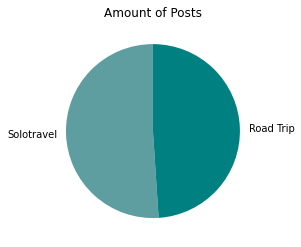

In [995]:
# Visual to show fairness of data (if needed for presentation)
plt.pie(x=df['subreddit'].value_counts(), colors=['cadetblue','teal'], startangle=90, labels=['Solotravel','Road Trip']);
plt.title('Amount of Posts');

#### Create a new column with text from 'selftext' and 'title' called 'alltext'

In [996]:
df3['alltext'] = df3['selftext'] + df3['title']
df3.head()

,subreddit,selftext,title,alltext
0,solotravel,In the interest of compiling all the informati...,CoVID-19 Monthly Megathread - March - 2021,In the interest of compiling all the informati...
1,solotravel,This thread is for y'all to do things like\n\n...,"/r/solotravel ""The Weekly Common Room"" - Gener...",This thread is for y'all to do things like\n\n...
2,solotravel,Hey so I’ve had a trip planned in my head for ...,A brit in the US (is September risky?),Hey so I’ve had a trip planned in my head for ...
3,solotravel,"Hi everyone, I am planning a solo trip for thi...","Questions for a trip to Boston, MA","Hi everyone, I am planning a solo trip for thi..."
4,solotravel,Hi! I'm a french looking to go in the US this ...,How to find a Summer job in the US as a french...,Hi! I'm a french looking to go in the US this ...


In [997]:
# Check if null values still remain
df3['alltext'].isnull().sum()

0

### Feature Engineering
#### Using the function below to clean the text

In [998]:
def sentence_to_words(sentence):
    # Function to convert a sentence to a string of words
    # The input is a single string, and 
    # the output is a single string
    p_stemmer = PorterStemmer()
    
    # 1. Remove HTML.
    sentence = BeautifulSoup(sentence).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", sentence)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = stopwords.words('english')
    stops.extend(['solo','road','solotravel','roadtrip','roadtripp','cheersroadtrip','eroadtrip','soloer','solotrip'])
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Stemming
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    stops = stopwords.words('english')
    stops.extend(['solo','road','solotravel','roadtrip','roadtripp'])
    meaningful_words = [w for w in meaningful_words if w not in stops]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [999]:
clean_text = []

print("Cleaning and parsing the training data set...")

# Instantiate counter.
j = 0

# For every review in our training set...
for text in df3['alltext']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_text.append(sentence_to_words(text))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 100 == 0:
        print(f'Cleaned {j + 1} of {df3.shape[0]}.')
    
    j += 1

Cleaning and parsing the training data set...
Cleaned 100 of 1818.
Cleaned 200 of 1818.
Cleaned 300 of 1818.
Cleaned 400 of 1818.
Cleaned 500 of 1818.
Cleaned 600 of 1818.
Cleaned 700 of 1818.
Cleaned 800 of 1818.
Cleaned 900 of 1818.
Cleaned 1000 of 1818.
Cleaned 1100 of 1818.
Cleaned 1200 of 1818.
Cleaned 1300 of 1818.
Cleaned 1400 of 1818.
Cleaned 1500 of 1818.
Cleaned 1600 of 1818.
Cleaned 1700 of 1818.
Cleaned 1800 of 1818.


In [1000]:
# Checking for cleaned texts
clean_text[100]

'never realli driven anywher outsid home state never driven longer like minut time abl drive sinc like turn sure make nervou littl nervou drive reason drive back airport afraid get lost someth way miss flight realli want go got free ticket resort leadvil colorado think nice get away littl bit recent start snowboard month ago love look forward everi time go think last thing enjoy much hometown ski area run like minut long tip calm nerv fli colorado snowboard trip month worri flight hour drive leadvil denver tip'

In [1001]:
# Checking for cleaned texts
clean_text[1200]

'travel west tennesse boston upstat new york know good spot along way love everyth cave trail shop restaur etc known spot along rout'

#### Add the clean text back to the dataset that we are working with

In [1002]:
df3['clean_text'] = clean_text
df3.head()

,subreddit,selftext,title,alltext,clean_text
0,solotravel,In the interest of compiling all the informati...,CoVID-19 Monthly Megathread - March - 2021,In the interest of compiling all the informati...,interest compil inform question relat covid on...
1,solotravel,This thread is for y'all to do things like\n\n...,"/r/solotravel ""The Weekly Common Room"" - Gener...",This thread is for y'all to do things like\n\n...,thread thing like introduc commun ask simpl qu...
2,solotravel,Hey so I’ve had a trip planned in my head for ...,A brit in the US (is September risky?),Hey so I’ve had a trip planned in my head for ...,hey trip plan head long time obvious postpon d...
3,solotravel,"Hi everyone, I am planning a solo trip for thi...","Questions for a trip to Boston, MA","Hi everyone, I am planning a solo trip for thi...",hi everyon plan trip summer boston chose spot ...
4,solotravel,Hi! I'm a french looking to go in the US this ...,How to find a Summer job in the US as a french...,Hi! I'm a french looking to go in the US this ...,hi french look go us summer unfortun find anyt...


#### Set up a new column to map which subreddit the posts came from
- Solotravel = 1
- Roadtrip = 0

In [1003]:
# Map each subreddit with a number
df3['classifier'] = df3['subreddit'].map({'solotravel':1, 'roadtrip':0}) 

In [1004]:
# Making sure that the value created is correct.
df3.groupby('subreddit')['classifier'].unique()

subreddit
roadtrip      [0]
solotravel    [1]
Name: classifier, dtype: object

In [1005]:
df3.head(1)

,subreddit,selftext,title,alltext,clean_text,classifier
0,solotravel,In the interest of compiling all the informati...,CoVID-19 Monthly Megathread - March - 2021,In the interest of compiling all the informati...,interest compil inform question relat covid on...,1


In [1006]:
# Export new cleaned data
df3.to_csv('cleaned_soloXroad.csv', index = False)

#### Train, test and split the data

In [1007]:
X = df3['clean_text'] # variable we want to analyze
y = df3['classifier'] # variable we want to predict

In [1008]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [1009]:
print(X_train.shape, X_test.shape)

(1363,) (455,)


In [1010]:
print(y_train.shape, y_test.shape)

(1363,) (455,)


#### Baseline model

In [1011]:
y.value_counts(normalize=True)

1    0.510451
0    0.489549
Name: classifier, dtype: float64

### Modelling

#### Count Vectorizer Default

In [1012]:
# Instantiate Count Vectorizer.
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None)

In [1013]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

#### TF-IDF Vectorizer Default

In [1014]:
tvec = TfidfVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None)

In [1015]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

#### LogisticRegression Default with CVEC

In [1016]:
# Instantiate logistic regression model.
lr = LogisticRegression()

# Fit model to training data.
lr.fit(X_train_cvec,y_train)

# Evaluate model on training data.
print("Training CountVectorizer LR Score:",lr.score(X_train_cvec, y_train).round(4))

# Evaluate model on testing data.
print("Testing CountVectorizer LR Score:",lr.score(X_test_cvec, y_test).round(4))

Training CountVectorizer LR Score: 0.9985
Testing CountVectorizer LR Score: 0.8659


- Training data is able to correctly predict nearly all posts.
- Model is still very overfit.

#### LogisticRegression Default with TVEC

In [1017]:
# Instantiate logistic regression model.
lr = LogisticRegression()

# Fit model to training data.
lr.fit(X_train_tvec, y_train)

# Evaluate model on training data.
print("Training TFIDFVectorizer LR Score:",lr.score(X_train_tvec,y_train).round(4))

# Evaluate model on testing data.
print("Testing TFIDFVectorizer LR Score:",lr.score(X_test_tvec, y_test).round(4))

Training TFIDFVectorizer LR Score: 0.9545
Testing TFIDFVectorizer LR Score: 0.8879


- Model is still very overfit.
- However, it does better than using CVEC

#### KNeighborsClassifier Default with CVEC

In [1018]:
knn = KNeighborsClassifier()
knn.fit(X_train_cvec, y_train)

KNeighborsClassifier()

In [1019]:
# Score our model on the training set.
print("KNN CVEC Training Score",knn.score(X_train_cvec,y_train).round(4))

# Score our model on the testing set.
print("KNN CVEC Testing KNN Score",knn.score(X_test_cvec,y_test).round(4))

KNN CVEC Training Score 0.7293
KNN CVEC Testing KNN Score 0.6264


- Model is very overfit.
- Also has very low accuracy score.

#### KNeighborsClassifier Default with TVEC

In [1020]:
knn = KNeighborsClassifier()
knn.fit(X_train_tvec, y_train)

KNeighborsClassifier()

In [1021]:
# Score our model on the training set.
print("KNN TVEC Training Score",knn.score(X_train_tvec,y_train).round(4))

# Score our model on the testing set.
print("KNN TVEC Testing Score",knn.score(X_test_tvec,y_test).round(4))

KNN TVEC Training Score 0.8995
KNN TVEC Testing Score 0.8637


- Model is slightly overfit
- However, it does alot better than CVEC

####  MultiNomial Naive Bayes with CVEC Default

In [1022]:
nb = MultinomialNB()
# Fit our model!
nb_model = nb.fit(X_train_cvec, y_train)

In [1023]:
# Score our model on the training set.
print("Training NB CVEC Score:",nb.score(X_train_cvec, y_train).round(4))

# Score our model on the testing set.
print("Testing NB CVEC Score:",nb.score(X_test_cvec, y_test).round(4))

Training NB CVEC Score: 0.9332
Testing NB CVEC Score: 0.8923


- Model is slightly overfit.

#### MultiNomial Naive Bayes with TVEC Default

In [1024]:
nb = MultinomialNB()
# Fit our model!
nb_model = nb.fit(X_train_tvec, y_train)

In [1025]:
# Score our model on the training set.
print("Training NB TVEC Score:",nb.score(X_train_tvec, y_train).round(4))

# Score our model on the testing set.
print("Testing NB TVEC Score:",nb.score(X_test_tvec, y_test).round(4))

Training NB TVEC Score: 0.923
Testing NB TVEC Score: 0.8637


- Model is slightly overfit.
- The accuracy is lower when using TVEC.
- NB with CVEC performs better in this case.

### Best performing model using all default parameters is KNeighbors Classifier with TVEC

#### Number of total features using Count Vectorizer and TF-IDF Vectorizer

In [1026]:
len(cvec.get_feature_names())

7460

In [1027]:
len(tvec.get_feature_names())

7460

### Modeling with GridSearch using hyperparameters

Create pipeline

In [1028]:
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression()),
])

pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression()),
])

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB()),
])

pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier()),
])

pipe_tvec_knn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier()),
])

Creating Hyperparameters excluding default values

In [1029]:
pipe_params_cvec_lr = {'cvec__max_features':[2000,3000,4000,5000],
                       'cvec__min_df':[2,3],
                       'cvec__max_df':[0.9,0.95],
                       'cvec__ngram_range':[(1,2),(1,3)]}

pipe_params_tvec_lr = {'tvec__max_features':[2000,3000,4000,5000],
                       'tvec__min_df':[2,3],
                       'tvec__max_df':[0.9,0.95],
                       'tvec__ngram_range':[(1,2), (1,3)]}

pipe_params_cvec_nb = {'cvec__max_features':[2000,3000,4000,5000],
                        'cvec__min_df':[2,3],
                        'cvec__max_df':[0.9,0.95],
                        'cvec__ngram_range':[(1,2), (1,3)],
                        'nb__alpha':[2,3]}

pipe_params_tvec_nb = {'tvec__max_features':[2000,3000,4000,5000],
                        'tvec__min_df':[2,3],
                        'tvec__max_df':[0.9,0.95],
                        'tvec__ngram_range':[(1,2), (1,3)],
                        'nb__alpha':[2,3]}

pipe_params_cvec_knn = {'cvec__max_features':[2000,3000,4000,5000],
                        'cvec__min_df':[2,3],
                        'cvec__max_df':[0.9,0.95],
                        'cvec__ngram_range':[(1,2), (1,3)],
                        'knn__n_neighbors':[6,7,8,9,10]}

pipe_params_tvec_knn = {'tvec__max_features':[2000,3000,4000,5000],
                        'tvec__min_df':[2,3],
                        'tvec__max_df':[0.9,0.95],
                        'tvec__ngram_range':[(1,2), (1,3)],
                        'knn__n_neighbors':[6,7,8,9,10]}

Using Gridsearch

In [1030]:
def gridsearch_model(pipeline,hyperparameter):
    gs = GridSearchCV(estimator=pipeline, # what object are we optimizing?
                  param_grid = hyperparameter, # what parameters values are we searching?
                  cv=5)
    gs.fit(X_train, y_train)
    print("Best score CV:",gs.best_score_.round(4)) # cross val score
    gs_model = gs.best_estimator_
    print(" ")
    print("Best params:",gs.best_params_)
    print("Train Score:",gs_model.score(X_train, y_train).round(4))
    print("Test Score:",gs_model.score(X_test, y_test).round(4))

#### LogisticRegression with CVEC using hyperparameter

In [1031]:
gridsearch_model(pipe_cvec_lr,pipe_params_cvec_lr)

Best score CV: 0.8753
 
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9985
Test Score: 0.8703


Compare with default paramters:
- Training CountVectorizer LR Score: 0.9985
- Testing CountVectorizer LR Score: 0.8659

##### Adjusting with hyperparameter gives a better result

#### LogisticRegression with TVEC using hyperparameter

In [1032]:
gridsearch_model(pipe_tvec_lr,pipe_params_tvec_lr)

Best score CV: 0.9068
 
Best params: {'tvec__max_df': 0.9, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Train Score: 0.9508
Test Score: 0.8989


Compare with default paramters:
- Training TFIDFVectorizer LR Score: 0.9545
- Testing TFIDFVectorizer LR Score: 0.8879

##### Adjusting with hyperparameter gives better result. 
- TVEC gives a better result than CVEC for Logistic Regression.

#### KNeighbors Classifier with CVEC using hyperparameter

In [1033]:
gridsearch_model(pipe_cvec_knn,pipe_params_cvec_knn)

Best score CV: 0.6684
 
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'knn__n_neighbors': 9}
Train Score: 0.6919
Test Score: 0.611


Compare with default parameters:
- KNN CVEC Training Score 0.7293
- KNN CVEC Testing Score 0.6264

##### Adjusting with hyperparameters gives a better result. 

#### KNeighbors Classifier with TVEC using hyperparameter

In [1034]:
gridsearch_model(pipe_tvec_knn,pipe_params_tvec_knn) 

Best score CV: 0.7013
 
Best params: {'knn__n_neighbors': 9, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Train Score: 0.5055
Test Score: 0.5011


Compare with default parameters:
- KNN TVEC Training Score 0.8995
- KNN TVEC Testing Score 0.8637

##### Adjusting with hyperparameters gives a better result in very low overfit.
- However, accuracy score is also very low as compared to default model.
- Due to accuracy score, KNN with CVEC does better.

#### Multinomial Naive Bayes with CVEC using hyperparameter

In [1035]:
gridsearch_model(pipe_cvec_nb,pipe_params_cvec_nb)

Best score CV: 0.8694
 
Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'nb__alpha': 2}
Train Score: 0.9149
Test Score: 0.9011


Compare with default parameters:
- Training NB CVEC Score: 0.9332
- Testing NB CVEC Score: 0.8923

##### Adjusting with hyperparameters gives better result.

#### Multinomial Naive Bayes with TVEC using hyperparameter

In [1036]:
gridsearch_model(pipe_tvec_nb,pipe_params_tvec_nb)

Best score CV: 0.8657
 
Best params: {'nb__alpha': 2, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
Train Score: 0.909
Test Score: 0.9055


Compare with default parameters:
- Training NB TVEC Score: 0.923
- Testing NB TVEC Score: 0.8637

##### Adjusting with hyperparameters gives better result.
- TVEC gives a better result than CVEC with very no overfitting.

# Conclude the model findings

### Best Model as per Grid Search (also better performance than using default parameters)
#### Naive Bayes Multinomial with TF-IDF Vectorizer
- Train Score: 0.909
- Test Score: 0.9055
         
     - max_df = 0.9
     - min_df = 3
     - max_features = 2000
     - ngram_range = (1,2)
     - alpha = 2

#### Interpreting the best model
- Very low overfit. Therefore, a good model to use
- max_df: ignore terms that appear in more than 90% of the documents.
- min_df: ignore terms that appear in less than 5 documents.
- max_features = only words that occur most frequently in top 2000 is required
- ngram_range: a pair of words help predict unseen data better
- alpha: A little bit of smoothing.

### Continuing using Model with Best Results to make predictions

In [1037]:
# Instantiate TD-IDF Vectorizer with best hyperparameter from Gridsearch.
tvec_nb = TfidfVectorizer(analyzer = "word",tokenizer = None,preprocessor = None,stop_words = None,
                       max_df=0.9, min_df=3,max_features=2000,ngram_range=(1,2))

In [1038]:
X_train_tvec_nb = tvec_nb.fit_transform(X_train)
X_test_tvec_nb = tvec_nb.transform(X_test)

In [1039]:
nb = MultinomialNB(alpha=2)
# Fit our model!
nb_model = nb.fit(X_train_tvec_nb, y_train)

In [1040]:
# Score our model on the training set.
print("Training NB TVEC Score:",nb_model.score(X_train_tvec_nb, y_train).round(4))

# Score our model on the testing set.
print("Testing NB TVEC Score:",nb_model.score(X_test_tvec_nb, y_test).round(4))

Training NB TVEC Score: 0.909
Testing NB TVEC Score: 0.9055


In [1041]:
# Generate predictions
predictions_nb_tvec = nb_model.predict(X_test_tvec_nb)
predictions_nb_tvec

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,

### Constructing Confusion Matrix from predictions made

- True Positive: Predict solotravel, it is solotravel
- False Positive: Predict solotravel, but it is roadtrip
- False Negative: Predict not solotravel (predict roadtrip), but it is solotravel
- True Negative: Predict not solotravel (predict roadtrip), it is roadtrip

In [1042]:
confusion_matrix(y_test, predictions_nb_tvec)

array([[194,  29],
       [ 14, 218]], dtype=int64)

In [1043]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_nb_tvec).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 194
False Positives: 29
False Negatives: 14
True Positives: 218


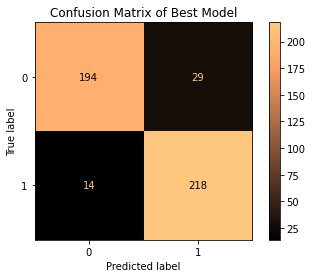

In [1044]:
plot_confusion_matrix(nb,X_test_tvec_nb,y_test,cmap='copper')
plt.title('Confusion Matrix of Best Model');

In [1045]:
# Model evaluation
print('Accuracy:', round(((tp+tn)/(tp+tn+fp+fn)),4))
print('Misclassification:',round(((fp+fn)/(tp+tn+fp+fn)),4))
print('Sensitivity:', round(((tp)/(tp+fn)),4))
print('Specificity:', round(((tn)/(tn+fp)),4))
print('Precision:', round(((tp)/(tp+fp)),4))

Accuracy: 0.9055
Misclassification: 0.0945
Sensitivity: 0.9397
Specificity: 0.87
Precision: 0.8826


#### Interpretation of the Confusion Matrix

- Our chosen model shows a high accuracy score of correct predictions.
- Model incorrectly predicts around 9.5% of posts.
- Out of all the positive classes, our model predicted a very good sensitivity score.
- There are about 14 words which are incorrectly predicted to be Roadtrip, but actually it comes from posts in Solotravel.
- There are 29 words which are incorrectly predicted to be Solotravel, but actually it comes from posts in Roadtrip.

We probably want to find some combination of sensitivity and specificity. 
- Focusing only on sensitivity means we minimize false negatives. This means there will be few posts we incorrectly predict to be solotravel, but more posts we incorrectly predict to be roadtrip.
- Focusing only on specificity means we minimize false positives. This means there will be few posts we incorrectly predict to be roadtrip, but more posts we incorrectly predict to be solotravel.

As we are only gathering features that relate to the same topic and not have any health implications or other serious implication, we can focus on improving our accuracy score instead.
- Removing some words that overlap in both classification would certainly help improve accuracy.
- An update of new posts might need to be gathered on a daily basis for a certain period of time to ensure lasting results.

#### ROC AUC
The more area under the curve is, the better separated our distributions are.

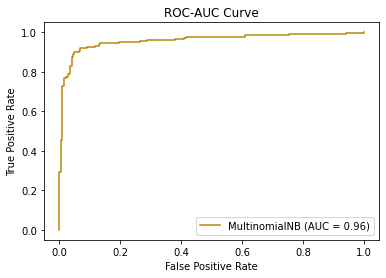

In [1046]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(nb, X_test_tvec_nb, y_test, color='darkgoldenrod');
plt.title('ROC-AUC Curve');

### Find posts that are wrongly predicted

In [1047]:
# Create a dataframe with predictions, true value and actual posts
false_df = pd.DataFrame({'predictions':predictions_nb_tvec,'actual':y_test,'text':X_test})
false_df

,predictions,actual,text
1363,0,0,tent plan trip summer wife use long day car dr...
776,1,1,hello plan hike everest base camp winter covid...
1433,0,0,drive palo duro canyon buddi second largest ca...
597,1,1,import flight come wait like hour initi hour c...
649,1,1,consid corona probabl eas rollout vaccin withi...
269,1,1,hey everyon plan year long work visa australia...
955,0,0,rise shine geocach travel friend today day day...
1591,1,0,u glitchyent post inspir share map
663,1,1,hey friend alway avid reader love take least t...
542,1,1,away travel long term find constant transient ...


In [1048]:
# Create a new column to find which posts are wrong
false_df['wrong_predictions'] = false_df['predictions'] - false_df['actual']

# Filter to keep only wrong predictions

# predicted Solotravel, but actually Roadtrip
false_positive_df = false_df.loc[(false_df['wrong_predictions'] == 1)]
false_positive_df 

,predictions,actual,text,wrong_predictions
1591,1,0,u glitchyent post inspir share map,1
1709,1,0,link http form gle rkt dmjkzbt chde hi everyon...,1
975,1,0,could go anywher us entir month june would go ...,1
1186,1,0,recent tri reserv car onlin budget enter debit...,1
1314,1,0,question travel michigan day would like know m...,1
1403,1,0,alreadi post r travel peopl might littl specif...,1
1814,1,0,snowi whip laps,1
1570,1,0,start explor local backroad,1
1691,1,0,dear fellow year sinc post ask advic http www ...,1
1168,1,0,f go tough time realli want take trip somewher...,1


In [1049]:
# predicted Roadtrip, but actually Solotravel
    
false_negative_df = false_df.loc[(false_df['wrong_predictions'] == - 1)]
false_negative_df

,predictions,actual,text,wrong_predictions
744,0,1,drive az three day mostli hike plan spend time...,-1
10,0,1,live lo angel pretti familiar west coast drive...,-1
723,0,1,back septemb ask secret spot great backcountri...,-1
133,0,1,f plan amtrak trip around unit state summer pa...,-1
859,0,1,april next year drive tucson work busi purpos ...,-1
3,0,1,hi everyon plan trip summer boston chose spot ...,-1
235,0,1,f love hike new ish backpack alway want cross ...,-1
393,0,1,go trip across us next six month explor lot na...,-1
878,0,1,work amazon total remot flexibl hour reloc sea...,-1
684,0,1,futur plan trip question travel within countri...,-1


#### Construct a framework to see words that are dominant for each categories

In [1050]:
count_df = pd.DataFrame(X_train_tvec_nb.todense(),columns=tvec_nb.get_feature_names())
count_df

,abil,abl,abl go,abl travel,abroad,abroad http,absolut,accent,accept,access,accommod,accommod recommend,accommod thread,account,across,across countri,across us,act,activ,actual,ad,add,addit,adult,advanc,adventur,advic,advic would,advis,affect,afford,afraid,africa,afternoon,afterward,age,ago,ahead,air,air bnb,airbnb,airlin,airport,albuquerqu,allow,almost,alon,along,along way,alreadi,also,also like,also love,also want,altern,although,alway,alway want,amaz,america,american,amount,amount time,amsterdam,angel,anim,anoth,answer,antelop,antelop canyon,anxieti,anxieti http,anxiou,anxiou travel,anybodi,anymor,anyon,anyon done,anyon els,anyon ever,anyon experi,anyon know,anyon recommend,anyon suggest,anyon tip,anyon travel,anyth,anyth like,anyway,anywher,apart,app,appar,appli,appreci,appreci advic,appreci thank,approach,april,arch,architectur,area,arequipa,arizona,around,around day,around europ,around time,around world,arriv,art,articl,asia,asian,asid,ask,ask accommod,ask meetup,ask question,ask simpl,aspect,aspect travel,assum,atlanta,atm,attempt,attract,august,austin,austin tx,australia,australian,auto,auto webp,avail,avail wiki,averag,avoid,awar,away,awaywego,awaywego blogspot,awesom,awhil,az,back,back home,background,backpack,backpack trip,bad,bag,balanc,balkan,ball,bank,bar,barcelona,base,basic,bathroom,bay,bay area,bc,beach,beat,beaten,beaten path,beauti,becom,bed,beer,begin,behind,believ,bend,berlin,besid,best,best place,best rout,best trip,best way,better,bf,big,big citi,big sur,big trip,biggest,bike,birthday,bit,black,block,blog,blog youtub,blogspot,blogspot com,blue,bnb,board,boat,bogot,bolivia,book,book flight,border,bore,boston,bottl,bought,box,boyfriend,brand,brand new,brazil,break,breakfast,bridg,bring,brother,bryce,bryce canyon,btt,btt travel,bu,bucket,bucket list,budapest,buddi,budget,bueno,bueno air,build,bulgaria,bunch,buse,busi,buy,ca,cafe,cairo,california,call,calm,cambodia,came,camp,camper,...,travel like,travel long,travel look,travel lot,travel mental,travel month,travel much,travel plan,travel share,travel stay,travel thing,travel time,travel tip,travel travel,travel world,treat,tree,trek,tri,tri figur,tri find,tri get,tri plan,trick,trip,trip across,trip advic,trip around,trip come,trip day,trip europ,trip go,trip last,trip like,trip next,trip plan,trip south,trip start,trip summer,trip want,trip would,troubl,truck,true,truli,tulum,turkey,turn,twenti,twice,two,two week,tx,type,typic,uber,uk,ultim,understand,unfortun,uni,uniqu,unit,unit state,univers,unless,unsur,upcom,updat,upon,us,usa,usd,use,use travel,usual,ut,utah,va,vacat,vaccin,vagu,valley,valu,valuabl,van,vancouv,variou,vega,vehicl,venic,ventur,via,vibe,victori,victori post,video,vienna,vietnam,view,villag,virginia,viru,visa,visit,visit friend,voucher,vs,wa,wait,wake,walk,walk around,wall,wanna,want,want ask,want complain,want drive,want get,want go,want hear,want know,want make,want see,want spend,want take,want travel,want visit,warm,warrant,warrant thread,washington,wast,watch,water,waterfal,way,way back,wear,weather,webp,websit,week,week novemb,week trip,week work,weekend,weird,welcom,well,went,west,west coast,western,western europ,whatev,whatev want,whenev,whether,whilst,white,whole,width,width format,wife,wifi,wiki,wiki btt,wiki eurotrip,wiki faq,wiki groupresourc,wiki http,wiki index,wiki link,wiki mentalhealth,wiki workingabroad,wild,wildlif,window,winter,wise,wish,within,without,woman,women,wonder,wonder anyon,word,work,work abroad,work holiday,work improv,work remot,workaway,workingabroad,workingabroad resourc,world,worri,wors,worst,worth,would,would abl,would also,would appreci,would get,would go,would good,would great,would greatli,would help,would like,would love,would much,would otherwis,would probabl,would realli,would recommend,would take,wow,write,wrong,www,www reddit,www youtub,wy,wyom,ye,year,year ago,year old,year plan,year travel,yellowston,yet,yo,york,yosemit,young,younger,youtub,youtub channel,youtub com,zealand,zero,zion,zion natio

In [1051]:
evel_df = pd.DataFrame(data={'roadtrip': nb.feature_log_prob_[0],'solotravel': nb.feature_log_prob_[1], 'word':count_df.columns})

In [1052]:
evel_df.head()

,roadtrip,solotravel,word
0,-7.910616,-8.046849,abil
1,-7.685684,-6.880399,abl
2,-8.079099,-7.949886,abl go
3,-8.063384,-7.752469,abl travel
4,-8.132055,-6.995403,abroad


Create a new column to evaluate score
- If score is negative, it means it appears more for Solotravel
- If score is positive, it means it appears more for Roadtrip

In [1053]:
evel_df['score'] = evel_df['roadtrip'] - evel_df['solotravel']
evel_df.head()

,roadtrip,solotravel,word,score
0,-7.910616,-8.046849,abil,0.136233
1,-7.685684,-6.880399,abl,-0.805285
2,-8.079099,-7.949886,abl go,-0.129213
3,-8.063384,-7.752469,abl travel,-0.310915
4,-8.132055,-6.995403,abroad,-1.136652


#### Most informative features that relate directly to Roadtrip

In [1054]:
evel_df.sort_values(by='solotravel').head(20)

,roadtrip,solotravel,word,score
141,-7.740554,-8.356864,awaywego blogspot,0.616310
642,-7.495049,-8.356864,friend plan,0.861815
1144,-7.304950,-8.356864,north carolina,1.051914
264,-7.089226,-8.356864,carolina,1.267638
163,-7.407301,-8.356864,bc,0.949563
162,-7.568937,-8.356864,bay area,0.787927
402,-7.477441,-8.356864,dalla,0.879423
1167,-7.511478,-8.356864,oklahoma,0.845387
666,-7.596881,-8.356864,geocach,0.759983
1455,-7.481912,-8.356864,savannah,0.874952


In [1055]:
direct_roadtrip = evel_df.sort_values(by='solotravel', ascending=True).head(10)
direct_roadtrip

,roadtrip,solotravel,word,score
141,-7.740554,-8.356864,awaywego blogspot,0.616310
642,-7.495049,-8.356864,friend plan,0.861815
1144,-7.304950,-8.356864,north carolina,1.051914
264,-7.089226,-8.356864,carolina,1.267638
163,-7.407301,-8.356864,bc,0.949563
162,-7.568937,-8.356864,bay area,0.787927
402,-7.477441,-8.356864,dalla,0.879423
1167,-7.511478,-8.356864,oklahoma,0.845387
666,-7.596881,-8.356864,geocach,0.759983
1455,-7.481912,-8.356864,savannah,0.874952


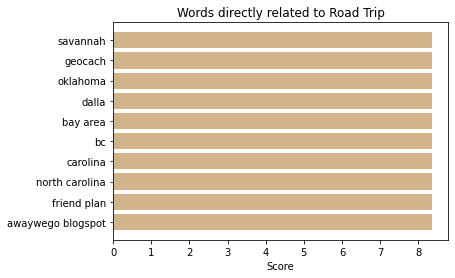

In [1056]:
plt.barh(y=direct_roadtrip['word'], width=direct_roadtrip['solotravel']*-1, color='tan');
plt.title('Words directly related to Road Trip')
plt.xlabel('Score');

#### Most informative features that relate directly to Solotravel

In [1057]:
evel_df.sort_values(by='roadtrip').head(20)

,roadtrip,solotravel,word,score
1385,-8.132055,-7.755504,reminisc,-0.376551
350,-8.132055,-7.599183,contin,-0.532872
348,-8.132055,-7.903364,content blog,-0.228691
981,-8.132055,-7.614369,love travel,-0.517686
345,-8.132055,-7.931124,constantli,-0.200931
1501,-8.132055,-7.903364,share victori,-0.228691
337,-8.132055,-7.903364,complain certain,-0.228691
336,-8.132055,-7.808949,complain,-0.323106
1503,-8.132055,-7.776919,shit,-0.355136
333,-8.132055,-8.127572,commun pleas,-0.004483


In [1058]:
direct_solo = evel_df.sort_values(by='roadtrip').head(10)
direct_solo

,roadtrip,solotravel,word,score
1385,-8.132055,-7.755504,reminisc,-0.376551
350,-8.132055,-7.599183,contin,-0.532872
348,-8.132055,-7.903364,content blog,-0.228691
981,-8.132055,-7.614369,love travel,-0.517686
345,-8.132055,-7.931124,constantli,-0.200931
1501,-8.132055,-7.903364,share victori,-0.228691
337,-8.132055,-7.903364,complain certain,-0.228691
336,-8.132055,-7.808949,complain,-0.323106
1503,-8.132055,-7.776919,shit,-0.355136
333,-8.132055,-8.127572,commun pleas,-0.004483


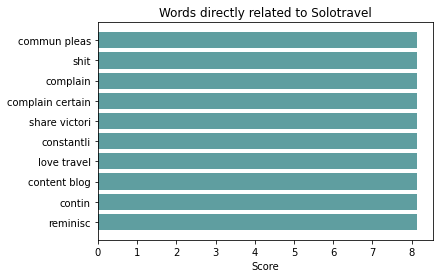

In [1059]:
plt.barh(y=direct_solo['word'], width=direct_solo['roadtrip']*-1, color='cadetblue');
plt.title('Words directly related to Solotravel')
plt.xlabel('Score');

#### Words that are dominant in corresponding to posts about 'Solotravel'
It is more likely that people who use these words are talking about Solotravel.

In [1060]:
# Top 10
evel_df.sort_values(by='score', ascending=False).tail(10)

,roadtrip,solotravel,word,score
4,-8.132055,-6.995403,abroad,-1.136652
590,-7.977285,-6.825609,feel like,-1.151675
1220,-7.092937,-5.919154,peopl,-1.173783
1456,-8.093137,-6.899517,save,-1.193619
918,-7.755725,-6.447670,life,-1.308056
1853,-8.009298,-6.688993,visa,-1.320305
1738,-6.430255,-4.907440,travel,-1.522815
588,-7.721414,-6.125191,feel,-1.596223
617,-7.977982,-6.343034,flight,-1.634949
772,-8.018183,-6.147745,hostel,-1.870438


In [1061]:
solotravel_dominant = evel_df.sort_values(by='score', ascending=False).tail(10)

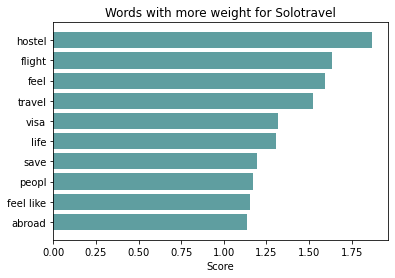

In [1062]:
plt.barh(y=solotravel_dominant['word'], width=solotravel_dominant['score']*-1, color='cadetblue');
plt.title('Words with more weight for Solotravel')
plt.xlabel('Score');

#### Words that are dominant in corresponding to posts about 'Roadtrip'
It is more like that people who use these words in their posts are talking about Roadtrip.

In [1063]:
# Top 10
evel_df.sort_values(by='score').tail(10)

,roadtrip,solotravel,word,score
753,-6.772173,-8.096498,highway,1.324325
1096,-6.136342,-7.470914,nation park,1.334572
1425,-5.973558,-7.343512,rout,1.369954
1269,-6.824451,-8.195942,playlist,1.371491
1602,-5.929522,-7.384024,stop,1.454502
256,-6.403723,-7.872637,canyon,1.468914
1827,-6.443685,-7.915405,utah,1.471720
1473,-6.702034,-8.188160,seattl,1.486126
243,-6.574470,-8.098319,california,1.523849
474,-5.410705,-6.942654,drive,1.531949


In [1064]:
roadtrip_dominant = evel_df.sort_values(by='score').tail(10)

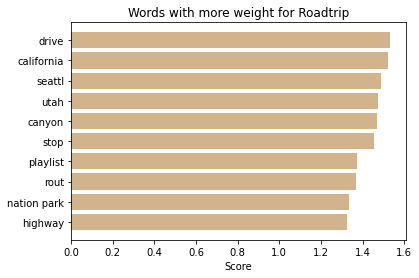

In [1065]:
plt.barh(y=roadtrip_dominant['word'], width=roadtrip_dominant['score'], color='tan');
plt.title('Words with more weight for Roadtrip')
plt.xlabel('Score');

### Constructing a word cloud of dominant words

Words that appear most frequently for Solotravel and Roadtrip, respectively.

In [1066]:
from wordcloud import WordCloud, STOPWORDS

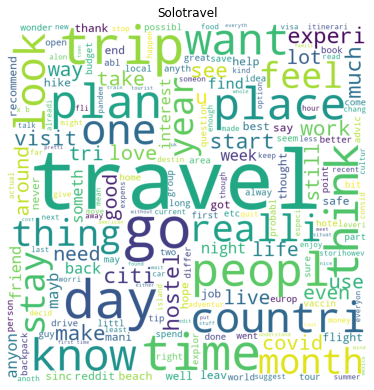

In [1067]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the dataset 
for val in df3[df3['classifier']==1]['clean_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Solotravel')
  
plt.show()

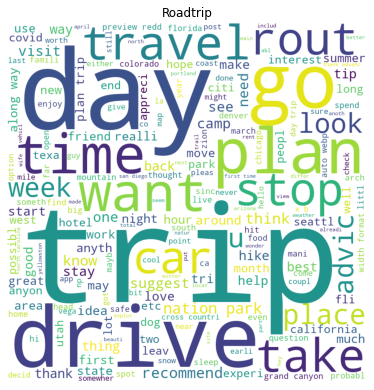

In [1068]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the dataset
for val in df3[df3['classifier']==0]['clean_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Roadtrip')
  
plt.show()

### Constructing word cloud for words wrongly predicted

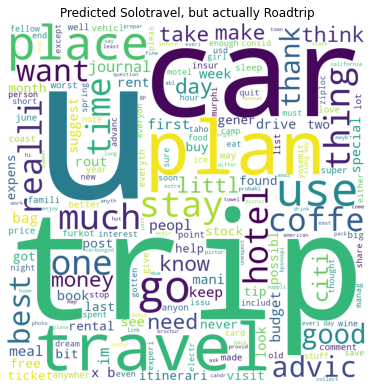

In [1069]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in false_positive_df[false_positive_df['wrong_predictions']==1]['text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Predicted Solotravel, but actually Roadtrip')
  
plt.show()

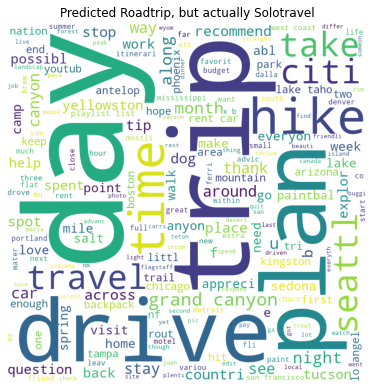

In [1070]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in false_negative_df[false_negative_df['wrong_predictions']==-1]['text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Predicted Roadtrip, but actually Solotravel')
  
plt.show()

## Conclusion and Recommendation

1. For people who like solo traveling, things such as information about ‘Visa’, ‘Flight’, and ‘Hostel’ would prove to be very helpful.

2. For road trips, a lot of words that relate to U.S. appear from this analysis as we can see many state names coming up. For example, Savannah, California and Grand Canyon. The company can look into partnering with hotels or motels from those places, and provide places to stop at for scenery or food as well.

3. Both posts has similar words that come up often such as ‘Plan’ and ‘Time’. The company can look into providing details about those when making travel itinerary.  

4. Since this model is biased towards United States, it will not be applicable to audience from elsewhere or who go to other countries. To offer full service, the company can look at their customer base and conduct analysis like this but using discussion platforms that more localized such as Pantip for Thailand. 

5. Since there is a high count of active global users of Reddit in the United States, our chance of bias towards providing information is slightly lower. However, taking information from one source is also not enough. Analysing other travel forums that are popular in the United States would also be necessary to provide more information. For example, Trip Advisor and Lonely Planet Forum
 
6. This model is likely to only be limited to a certain period of time as traveling and destinations depend highly on weather conditions and time of the year. The same set of information cannot be used for summer months and winter months.